In [2]:
from Hubbard_test import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

ModuleNotFoundError: No module named 'openfermion'

In [ ]:

# --- Parameters ---
#Note: mesolve scales poorly. Keep L very small (L=4 is already demanding).
L = 2
t_hopping = 1.0
U_interaction = [5]#[0, 0.1, 0.5, 1.0, 2.0, 5.0, 7.0, 9.0, 10.0, 12.0, 15.0, 17.0, 20.0]#5.0
J_NESS = []
for i in range(len(U_interaction)):
    mu_potential = U_interaction[i]/2  # Set mu = U/2 for half-filling

    print(f"Driven-Dissipative Hubbard Model for L={L}, t={t_hopping}, U={U_interaction[i]}")
    print("="*80)

    # --- 1. Build operators and find initial state ---
    start_time = time.time()
    print("1. Building operators and finding ground state...")
    num_qubits = 2 * L
    hubbard_hamiltonian_ferm = build_hubbard_hamiltonian(L, t_hopping, U_interaction[i], mu_potential)
    hamiltonian_matrix_sparse = get_sparse_operator(hubbard_hamiltonian_ferm, n_qubits=num_qubits)

    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian_matrix_sparse.toarray())
    ground_state = eigenvectors[:, 0]
    print(f"   -> Ground state energy: {eigenvalues[0]:.6f}")

    # Build the current operator to measure the flow
    j_op_ferm_list = build_current_operator(L, t_hopping)
    j_matrices_sparse = [get_sparse_operator(j, n_qubits=num_qubits) for j in j_op_ferm_list]
    print(f"   -> Setup took {time.time() - start_time:.2f} seconds.")

    t_max = 40.0            # Maximum evolution time
    Nt = 401         # Number of time steps

    # --- 2. Nonlinear Response via GKSL Evolution ---
    print("\n2. Calculating driven-dissipative response via GKSL time evolution...")

    
    gamma = 0.05
    #for i in tqdm(range(len(gamma))):
    gammas = [gamma, gamma]

    #start_time = time.time()
    times, current_t_list = calculate_driven_dissipative_current(
        hamiltonian_matrix_sparse, j_matrices_sparse, ground_state, 
        gammas[0], gammas[1], t_max, Nt
    )
    J_NESS.append(np.real(current_t_list[0][-1]))
    #print(f"   -> Time evolution complete. Time elapsed: {time.time() - start_time:.2f} seconds.")


Driven-Dissipative Hubbard Model for L=2, t=1.0, U=5


NameError: name 'time' is not defined

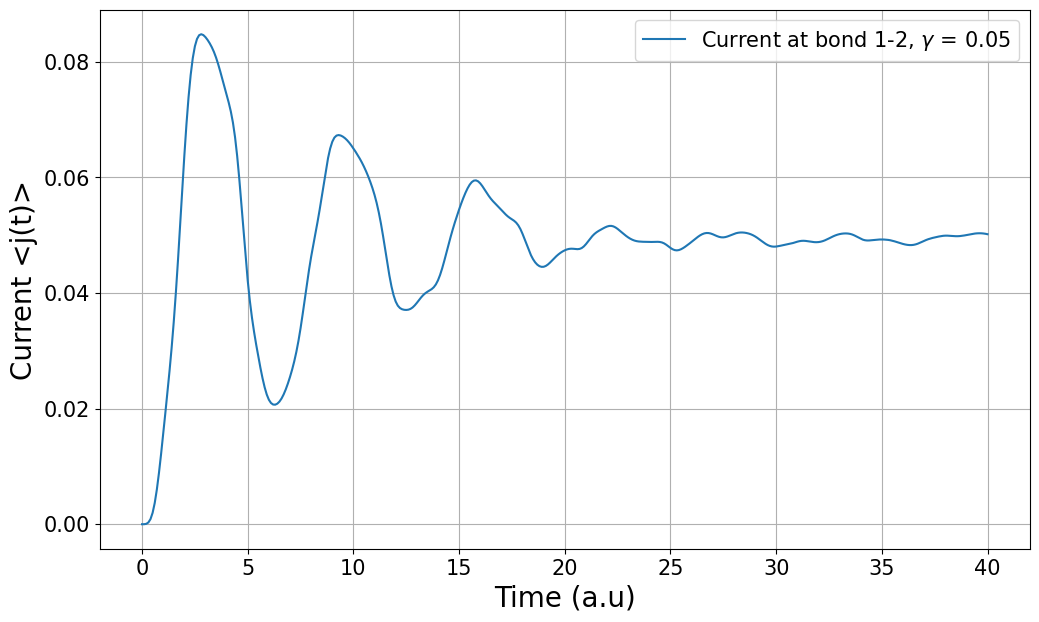


Analysis of Driven-Dissipative Response:
   -> Steady-state current (approx. in middle of chain): 0.049447


In [ ]:
# --- 3. Plotting and Analysis ---
plt.figure(figsize=(12, 7))
#for i, current_t in enumerate(current_t_list):
plt.plot(times, np.real(current_t_list[L// 2 -1]), label=f'Current at bond {L//2-1}-{L//2}, $\gamma$ = {gamma}')

plt.xlabel('Time (a.u)', fontsize = 20)
plt.ylabel('Current <j(t)>', fontsize = 20)
#plt.title(f'Driven-Dissipative Current in the Hubbard Model (L={L}, t = {t_hopping}, U = {U_interaction}, $\mu$ = {mu_potential})', fontsize = 20)
plt.grid(True)
plt.legend(fontsize = 15)
plt.tick_params(labelsize = 15)
plt.savefig('Current_x_t_smallgamma.png', format = 'png')
plt.show()


#plt.savefig('Current_x_U.png', format = 'png')

# To get the steady-state current, find the value where the plot flattens
# We'll analyze the current in the middle of the chain
mid_point_current = np.real(current_t_list[L // 2 - 1])
steady_state_current = np.mean(mid_point_current[-50:]) # Average last part
print(f"\nAnalysis of Driven-Dissipative Response:")
print(f"   -> Steady-state current (approx. in middle of chain): {steady_state_current:.6f}")

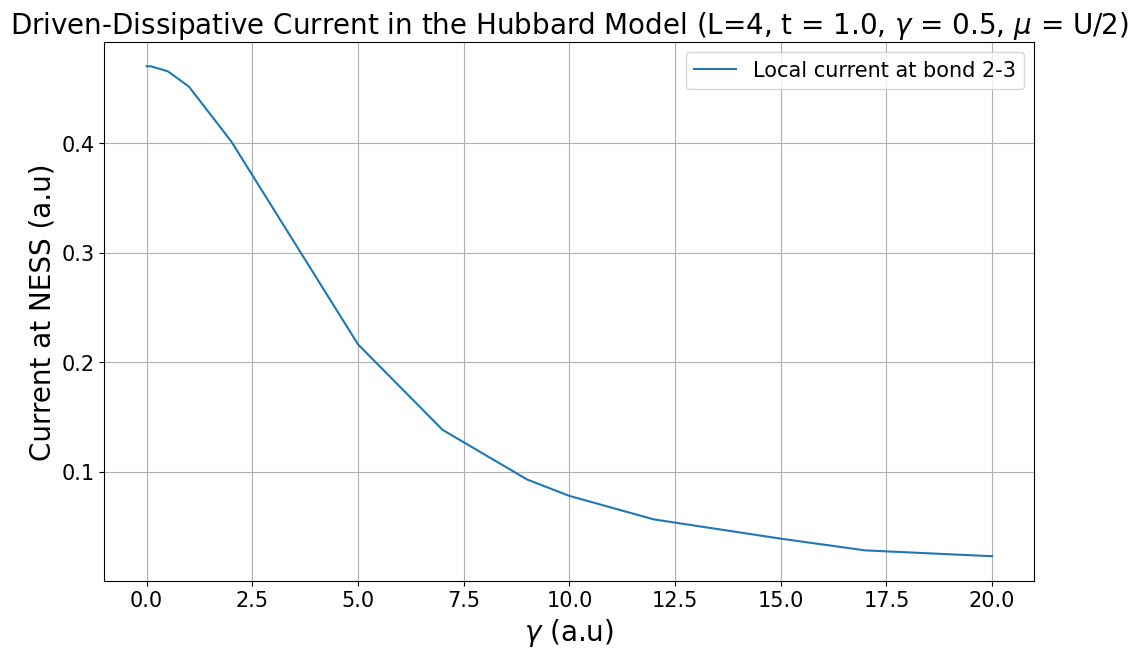


Analysis of Driven-Dissipative Response:
   -> Steady-state current (approx. in middle of chain): 0.025948


In [ ]:
#print(np.gradient(J_NESS, 0.005))

# --- 3. Plotting and Analysis ---
plt.figure(figsize=(12, 7))
plt.plot(U_interaction, J_NESS, label=f'Local current at bond {2}-{2+1}')

plt.xlabel(r'$\gamma$ (a.u)', fontsize = 20)
plt.ylabel('Current at NESS (a.u)', fontsize = 20)
plt.title(f'Driven-Dissipative Current in the Hubbard Model (L={L}, t = {t_hopping}, $\gamma$ = {gamma}, $\mu$ = U/2)', fontsize = 20)
plt.grid(True)
plt.legend(fontsize = 15)
plt.tick_params(labelsize = 15)

plt.savefig('Current_x_U.png', format = 'png')

plt.show()

# To get the steady-state current, find the value where the plot flattens
# We'll analyze the current in the middle of the chain
mid_point_current = np.real(current_t_list[L // 2 - 1])
steady_state_current = np.mean(mid_point_current[-50:]) # Average last part
print(f"\nAnalysis of Driven-Dissipative Response:")
print(f"   -> Steady-state current (approx. in middle of chain): {steady_state_current:.6f}")

In [ ]:
L = 4
t_hopping = 1.0
U_interaction = 5.0
mu_potential = U_interaction/2

print(f"Solving master equation with qutip.mesolve for L={L}")
print("="*70)

# --- 1. Build operators and initial state ---
print("1. Building operators and initial state...")
num_qubits = 2 * L
hamiltonian_ferm = build_hubbard_hamiltonian(L, t_hopping, U_interaction, mu_potential)
hamiltonian_matrix_sparse = get_sparse_operator(hamiltonian_ferm, n_qubits=num_qubits)

ground_energy, ground_state_vector = get_ground_state(hamiltonian_matrix_sparse)
print(f"   -> Ground state energy: {ground_energy:.4f}")

# Convert operators to QuTiP's Qobj format
H_qutip = qutip.Qobj(hamiltonian_matrix_sparse)

# Initial state is the density matrix of the ground state
rho0 = qutip.ket2dm(qutip.Qobj(ground_state_vector))

c_ops = []
cdag_ops = []
loss_op_ferm = annihilation_operator(0, 0, L)
loss_op_sparse = get_sparse_operator(loss_op_ferm, n_qubits=num_qubits)

loss1_op_ferm = annihilation_operator(1, 0, L)
loss1_op_sparse = get_sparse_operator(loss1_op_ferm, n_qubits=num_qubits)

creation_op_ferm = annihilation_operator(0, L-1, L)
creation_op_sparse = get_sparse_operator(creation_op_ferm, n_qubits=num_qubits)

creation1_op_ferm = annihilation_operator(1, L-1, L)
creation1_op_sparse = get_sparse_operator(creation_op_ferm, n_qubits=num_qubits)


c_ops.append(np.sqrt(gamma) * (qutip.Qobj(loss_op_sparse) + qutip.Qobj(loss1_op_sparse)))
cdag_ops.append(np.sqrt(gamma) * (qutip.Qobj(creation_op_sparse) + qutip.Qobj(creation1_op_sparse)))


numdn_op_ferm = creation_operator(0, 0, L) * annihilation_operator(0, 0, L)
numup_op_ferm = creation_operator(1, 0, L) * annihilation_operator(1, 0, L)
# Define observable to track
for i in range(1, L):
    numdn_op_ferm += creation_operator(0, i, L) * annihilation_operator(0, i, L)
    numup_op_ferm += creation_operator(1, i, L) * annihilation_operator(1, i, L)

    
numdn_op_qutip = qutip.Qobj(get_sparse_operator(numdn_op_ferm, n_qubits=num_qubits))
numup_op_qutip = qutip.Qobj(get_sparse_operator(numup_op_ferm, n_qubits=num_qubits))

# --- 2. Solve the Master Equation using qutip.mesolve ---
print("\n2. Solving with qutip.mesolve...")
t_list = np.linspace(0, 20, 201)

start_time = time.time()
# This is the master equation solver. It handles all the complexity internally.
result_dn = qutip.mesolve(H_qutip, rho0, t_list, c_ops, e_ops=[numdn_op_qutip])
result_up = qutip.mesolve(H_qutip, rho0, t_list, c_ops, e_ops=[numup_op_qutip])
result_tot = qutip.mesolve(H_qutip, rho0, t_list, c_ops, e_ops=[numdn_op_qutip + numup_op_qutip])
print(f"   -> Evolution took {time.time() - start_time:.2f} seconds.")

# --- 3. Plot the Results ---
print("\n3. Plotting results...")
expdn_values = result_dn.expect[0]
expup_values = result_up.expect[0]
exptot_values = result_tot.expect[0]


Solving master equation with qutip.mesolve for L=4
1. Building operators and initial state...
   -> Ground state energy: -11.6574

2. Solving with qutip.mesolve...
   -> Evolution took 6.70 seconds.

3. Plotting results...


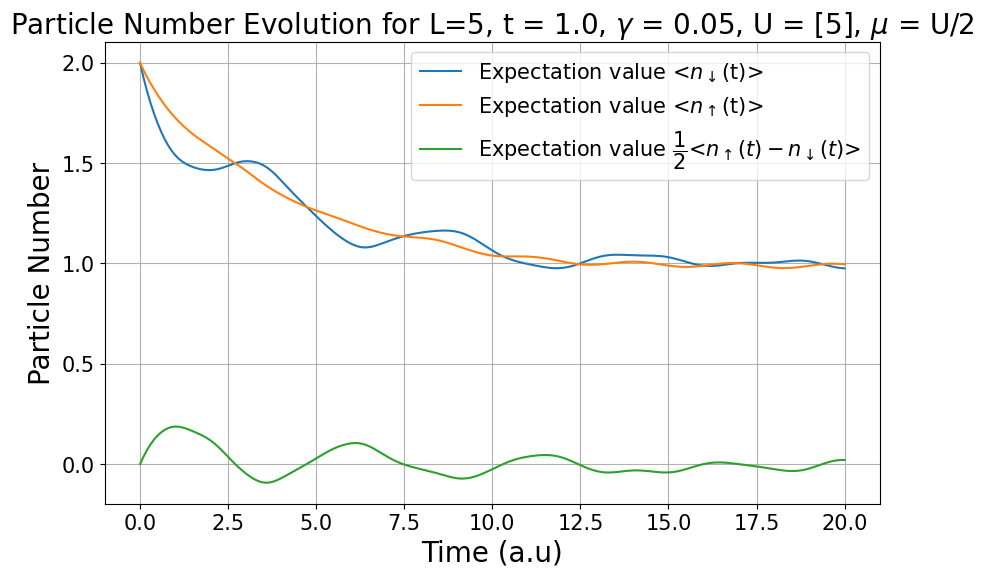

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t_list, expdn_values, label=r'Expectation value <$n_\downarrow$(t)>')
plt.plot(t_list, expup_values, label=r'Expectation value <$n_\uparrow$(t)>')
plt.plot(t_list, (expup_values-expdn_values), label=r'Expectation value $\dfrac{1}{2}$<$n_\uparrow(t) - n_\downarrow(t)$>')
plt.title(f'Particle Number Evolution for L={L}, t = {t_hopping}, $\gamma$ = {gamma}, U = {U_interaction}, $\mu$ = U/2', fontsize = 20)
plt.xlabel('Time (a.u)', fontsize = 20)
plt.ylabel('Particle Number', fontsize = 20)
plt.grid(True)
plt.legend(fontsize = 15)
plt.tick_params(labelsize = 15)

#plt.savefig('Density_x_t.png', format = 'png')
plt.show()